In [1]:
import pandas as pd
import tensorflow as tf

In [2]:
df=pd.read_csv("NSE-Tata-Global.txt",sep=',')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [3]:
df.shape

(2035, 8)

In [4]:
df1=df.reset_index()['Close']

In [5]:
df1.head()

0    233.75
1    233.25
2    234.25
3    236.10
4    233.30
Name: Close, dtype: float64

In [6]:
df1.shape


(2035,)

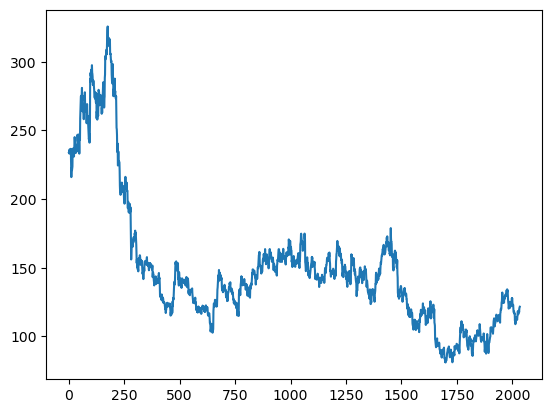

In [7]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [8]:
df1

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

In [9]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [10]:
df1

array([[0.62418301],
       [0.62214052],
       [0.62622549],
       ...,
       [0.1621732 ],
       [0.16319444],
       [0.16584967]])

Train-Test split is done using cross validation or random seed

In [11]:

training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [12]:
training_size,test_size

(1322, 713)

In [13]:
#pre processing to check time steps
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   #i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [14]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [15]:
print(X_train.shape), print(y_train.shape)
   

(1221, 100)
(1221,)


(None, None)

In [16]:
print(X_test.shape), print(ytest.shape)

(612, 100)
(612,)


(None, None)

In [17]:
#3d
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [18]:
# Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [19]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
20/20 [==============================] - 19s 412ms/step - loss: 0.0269 - val_loss: 0.0057
Epoch 2/50
20/20 [==============================] - 6s 280ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 3/50
20/20 [==============================] - 5s 273ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 4/50
20/20 [==============================] - 5s 274ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 5/50
20/20 [==============================] - 5s 276ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 6/50
20/20 [==============================] - 5s 275ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 7/50
20/20 [==============================] - 5s 275ms/step - loss: 0.0014 - val_loss: 9.7405e-04
Epoch 8/50
20/20 [==============================] - 5s 271ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 9/50
20/20 [==============================] - 5s 265ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/50
20/20 [==============================] - 5s 274ms/step - loss: 0.0012 - val_loss: 0

In [22]:
tf.__version__

'2.10.0'

In [23]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

20/20 [==============================] - 1s 62ms/step


In [24]:
#Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [25]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

167.99096017247487

In [26]:
math.sqrt(mean_squared_error(ytest,test_predict))

118.76913202022958

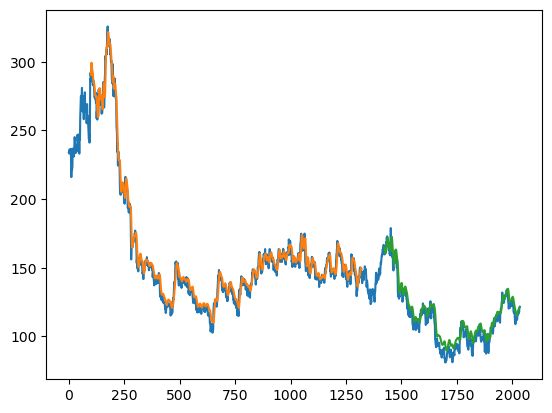

In [27]:
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [28]:
len(test_data)

713

In [29]:
x_input=test_data[613:].reshape(1,-1)
x_input.shape

(1, 100)

In [30]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [31]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.16853529]
101
1 day input [0.13848039 0.14011438 0.13888889 0.13541667 0.14011438 0.1380719
 0.13071895 0.13071895 0.12867647 0.11846405 0.14644608 0.14808007
 0.15910948 0.15992647 0.15788399 0.16441993 0.17892157 0.17933007
 0.19260621 0.20812908 0.18974673 0.18055556 0.18239379 0.17708333
 0.17810458 0.18055556 0.17810458 0.17851307 0.19607843 0.18913399
 0.18954248 0.19403595 0.19444444 0.20200163 0.19771242 0.19934641
 0.19873366 0.1997549  0.2128268  0.21568627 0.20445261 0.21772876
 0.21098856 0.21425654 0.19750817 0.18811275 0.17851307 0.17381536
 0.16033497 0.16564542 0.17116013 0.17422386 0.18035131 0.17401961
 0.16278595 0.16973039 0.17810458 0.17034314 0.16830065 0.17279412
 0.17544935 0.18382353 0.19138072 0.18913399 0.19097222 0.17238562
 0.16830065 0.1693219  0.17177288 0.16156046 0.14971405 0.1503268
 0.15196078 0.14726307 0.14501634 0.14603758 0.12479575 0.13112745
 0.11397059 0.1190768  0.12377451 0.13562092 0.12908497 0.13459967
 0.12806373 0.13031046 0.12724673 0

In [32]:
import numpy as np
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [33]:
import matplotlib.pyplot as plt

In [34]:
len(df1)-100

1935

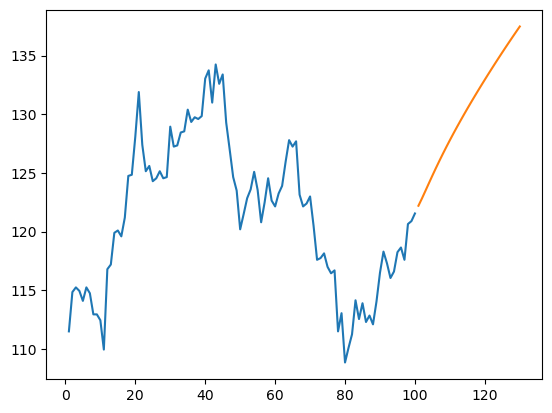

In [35]:
plt.plot(day_new,scaler.inverse_transform(df1[1935:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

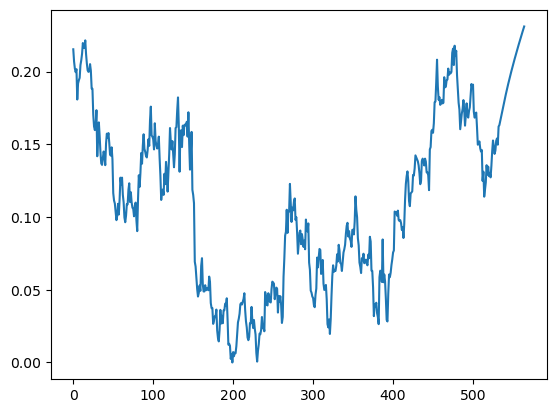

In [36]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1500:])

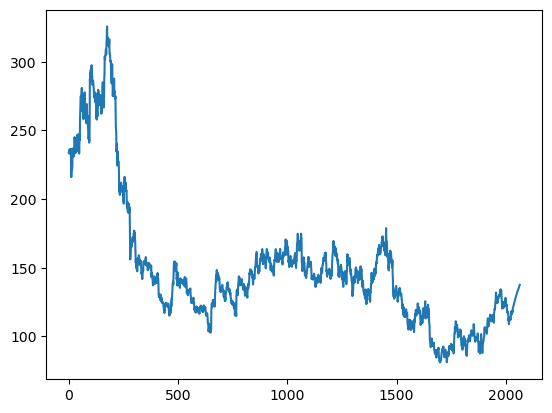

In [37]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)